In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=3)

In [3]:
def init_hamiltonian(N):
    """The uniform matrix"""
    v = np.ones((N,1))*(1/np.sqrt(N))
    return np.matmul(v, v.T.conj())

def problem_vector(N):
    pv = np.zeros((N,1))
    pv[N-1] = 1
    return pv
    
def problem_hamiltonian(N):
    pv = problem_vector(N)
    return np.matmul(pv, pv.T.conj())

def H_op(delt, n, H):
    """
    Input:
        delt: time interval
        n: number of qubits
        H: Hamiltonian matrix
    return Operator exp(-itH)
    """
    H = H*(-1j*delt)
    exp_H = expm(H)
    h = QuantumCircuit(n+1, name = 'H_op')
    h.unitary(exp_H, range(n))
    return h.to_gate()

def f(t, epsilon, N):
    """
    Time evolve function
    Input:
        t: time point
        epsilon: error value
        N: 2**n
    return value from 0 to 1
    """
    arg = ((2*epsilon*np.sqrt(N-1)*t)/N - np.arctan(np.sqrt(N-1)))
    num = np.tan(arg) / np.sqrt(N-1)
    den = 1 + num
    result = 0.5 * den
    # if result > 1 or result < 0:
    #     return 1
    return result

def linear_f(t, T):
    return t/T

def getT(epsilon, N):
    t1 = 1/(2*epsilon)
    t2 = N/np.sqrt(N-1)
    t3 = np.arctan((np.sqrt(N-1)))+np.arctan(np.sqrt(N-1))
    return t1*t2*t3

def getR(epsilon, N):
    """get the total iteration R"""
    return (int)(np.sqrt(N)/(epsilon**3))

def st_out(qc, n):
    """get the adjusted statevector"""
    out = Statevector.from_instruction(qc)
    out_red = partial_trace(out, [n])
    prob, st_all = la.eig(out_red.data)
    cond = (prob>0.99) & (prob<1.01)
    st = st_all[:, cond].ravel()
    return Statevector(st)

def getEpsilon(final_vector, m):
    """
    get the epsilon of the result, should lower than the theoretical epsilon

    ERRORS: Have problems!
    """
    distance_vector = final_vector.data
    if distance_vector[m-1] > 0:
        distance_vector[m-1] -= 1
    else:
        distance_vector[m-1] += 1
    return np.sqrt(np.sum(distance_vector.conj().T*distance_vector))


Total time T: 10.890755400276705
Total iteration R: 32
Result epsilon: (0.5660681700346668+0j)


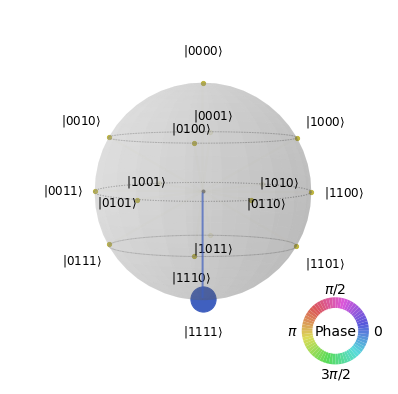

In [95]:

n = 4
N = 2**n
epsilon = 0.5

states = []
rs = []
es = []
fs = []
ts = []

T = getT(epsilon, N)
R = getR(epsilon, N)
# R = 3

circ = QuantumCircuit(n+1)
circ.h(range(n))

for r in range(1, R+1):
    t = r*(T/R)
    H0 = np.identity(N) - init_hamiltonian(N)
    Hp = np.identity(N) - problem_hamiltonian(N)
    circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n+1))
    circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n+1))

    # circ.append(H_op(T/R,n,(1-linear_f(t,T))*H0), range(n+1))
    # circ.append(H_op(T/R,n,H0+Hp), range(n+1))

    # H = (1-f(t,epsilon,N))*H0 + f(t,epsilon,N)*Hp
    # circ.append(H_op(T/R,n,H), range(n+1))

    states.append(st_out(circ, n))
    es.append(getEpsilon(st_out(circ, n), N))
    rs.append(r)
    fs.append(f(t,epsilon,N))
    ts.append(t)

print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print("Result epsilon: " + str(getEpsilon(states[R-1], N)))
out = partial_trace(Statevector(circ), [n])
plot_state_qsphere(out)

# print(getEpsilon(states[0], N))

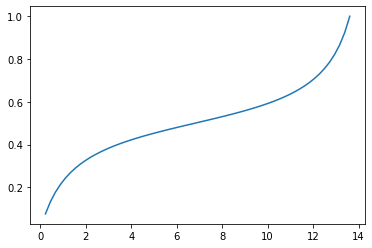

In [63]:
plt.plot(ts, fs)
plt.show()

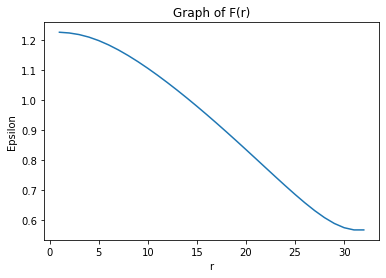

In [96]:
plt.plot(rs, es)
plt.xlabel('r')
plt.ylabel('Epsilon')
plt.title('Graph of F(r)')
plt.show()

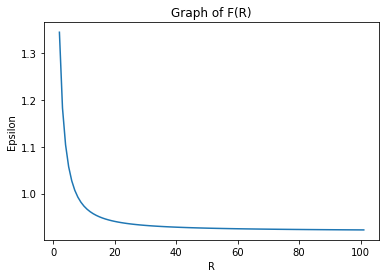

In [148]:
n = 6
N = 2**n
epsilon = 1
Rx = 100

states = []
Rs = []
es = []

T = getT(epsilon, N)

for R in range(2, Rx+2):
    circ = QuantumCircuit(n+1)
    circ.h(range(n))
    for r in range(1, R+1):
        t = r*(T/R)
        H0 = np.identity(N) - init_hamiltonian(N)
        Hp = np.identity(N) - problem_hamiltonian(N)
        circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n+1))
        circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n+1))

        # H = (1-f(t,epsilon,N))*H0 + f(t,epsilon,N)*Hp
        # circ.append(H_op(T/R,n,H), range(n+1))
    es.append(getEpsilon(st_out(circ, n), N))
    Rs.append(R)

plt.plot(Rs, es)
# plt.xlim([0, Rx])
plt.xlabel('R')
plt.ylabel('Epsilon')
plt.title('Graph of F(R)')
# plt.ylim([0, 2])
plt.show()

The best-fitting parameters are k=1.80, b=1.26, and c=0.49 and d=0.92
The function is y = ((1.80 / R) ** 1.26)*0.49 + 0.92 


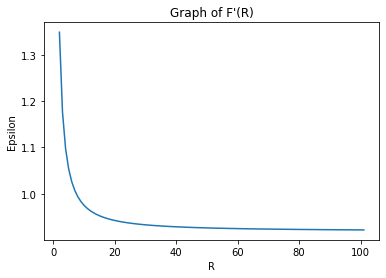

In [149]:
import numpy as np
from scipy.optimize import curve_fit

# Define the inverse proportional function
def inv_proportional(x, k, b, c, d):
    return ((k / x) ** b)*c + d

# Your data points
x_data = Rs
y_data = es

# Curve fitting
params, _ = curve_fit(inv_proportional, x_data, y_data)

# Extract the best-fitting parameters
k, b, c, d = params

print(f"The best-fitting parameters are k={k:.2f}, b={b:.2f}, and c={c:.2f} and d={d:.2f}")
print(f"The function is y = (({k:.2f} / R) ** {b:.2f})*{c:.2f} + {d:.2f} ")

e_values = np.array([inv_proportional(R, k, b, c, d) for R in Rs])
plt.plot(Rs, e_values)
# plt.xlim([0, Rx])
plt.xlabel('R')
plt.ylabel('Epsilon')
plt.title('Graph of F\'(R)')
plt.show()